<a href="https://colab.research.google.com/github/dimGitor/computer_vision/blob/master/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Images classificator**
> *Input data:*

cifar10: https://www.cs.toronto.edu/~kriz/cifar.html


## **Initialization**

### Instalation modules:

In [0]:
#!pip install mlxtend==0.17.0
#!pip install tensorflow==1.14
!pip install tensorflow --upgrade
#!pip install grpcio --upgrade
#!pip install grpcio==1.15.0
!pip install keras --upgrade
#!pip install keras==2.2.5
!pip install matplotlib --upgrade

### Import modules:

In [0]:
import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2

import numpy as np
from keras.preprocessing.image import ImageDataGenerator

#to visualization traingn reluts
import matplotlib as mp
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#to save model
from google.colab import files
from keras.models import load_model

print("tesorflow version:", tf.__version__)

### Initialize possible images classes:

In [0]:
class_names = ['самолёт', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

### Loading data from dataset:

In [0]:
(input_train_data, output_train_data), (input_test_data, output_test_data) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


## **Training**

### Normalization of data:

In [0]:
max_train = input_train_data.max()
input_train_data = input_train_data / max_train.astype(float)
input_test_data = input_test_data / max_train.astype(float)

My training set consists:

In [0]:
img_train_count = input_train_data.shape[0]
img_train_sizes = [input_train_data.shape[1], 
                   input_train_data.shape[2]]
img_color_train_count = input_train_data.shape[3] #count of images color channels
print("---training data---")
print("images count:", img_train_count)
print("image size:", img_train_sizes[0], "*", img_train_sizes[1])
print("images count of colors:", img_color_train_count) #RGB: must be 3

---training data---
images count: 50000
image size: 32 * 32
images count of colors: 3


My test set consist:

In [0]:
img_test_count = input_test_data.shape[0]
img_test_sizes = [input_test_data.shape[1], 
                  input_test_data.shape[2]]
img_color_test_count = input_test_data.shape[3]
print("---testing data---")
print("images count:", img_test_count)
print("image size:", img_test_sizes[0], "*", img_test_sizes[1])
print("images count of colors:", img_color_test_count) #RGB: must be 3

---testing data---
images count: 10000
image size: 32 * 32
images count of colors: 3


### **Creation neural networks:**

*It have to change to improve training:*

In [0]:
#for initialize neural network:
padding_name = "same"
padding_name_max_pool = "valid"
activation_name = "relu"
count_classes = 10

#for creation network:
optimizer_name = "sgd"
loss_name = "sparse_categorical_crossentropy"
metrix_names = ["sparse_categorical_accuracy", "accuracy"]
strides = 2
filter_count = 32

#for training created model:
batch_size = 32
epochs = 75
verbose = 2
patience = 13
droup_out = 0.3

Augmintation data

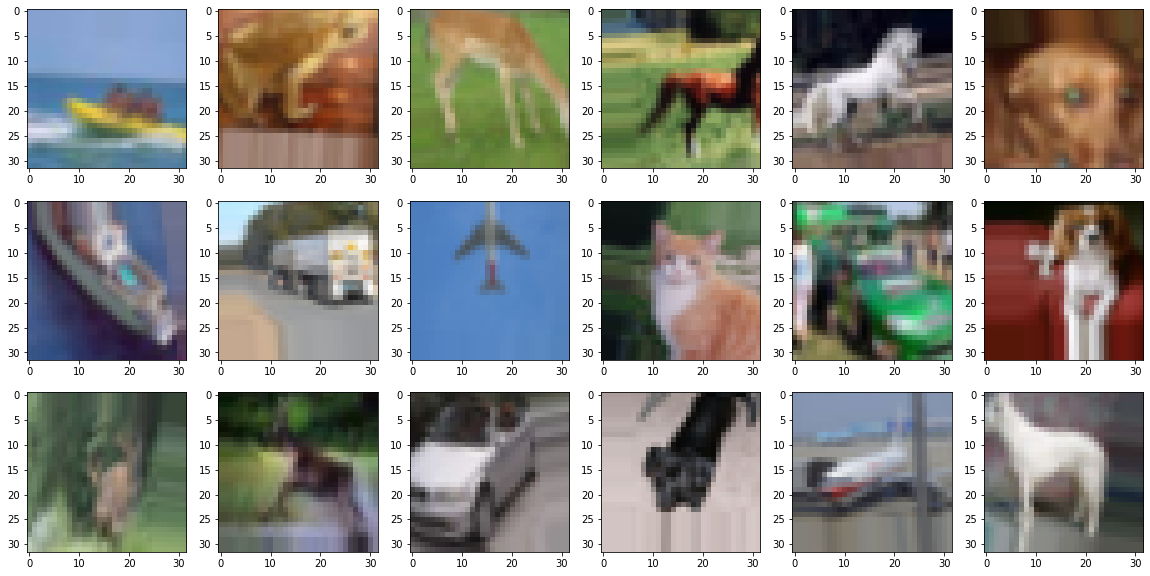

In [0]:
generator = ImageDataGenerator(
    rotation_range = 10, 
    zoom_range = 0.18, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    horizontal_flip = True)

cnt = 0
nrows = 3
ncols = 6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
for img_sample, _ in generator.flow(input_train_data, output_train_data, batch_size=batch_size):
    for img in img_sample:
        axes[cnt // ncols][cnt % ncols].imshow(img)
        cnt += 1
        if cnt >= nrows * ncols:
            break
    if cnt >= nrows * ncols:
        break

**N**eural **n**etwork:

In [0]:
model = Sequential([
# convolutional layer_1
L.Conv2D(
    filters = filter_count,  
    kernel_size = (3, 3), 
    padding = padding_name,
    activation = activation_name,    
    input_shape = [img_test_sizes[0], img_test_sizes[1], img_color_test_count]),
L.BatchNormalization(),
# subsamping layer_1
L.MaxPool2D(
    pool_size = (2, 2), 
    strides = strides, 
    padding = padding_name_max_pool),

# convolutional layer_2
L.Conv2D(
    filters = 2 * filter_count, 
    kernel_size = (3, 3), 
    padding = padding_name,
    #kernel_regularizer = keras.regularizers.l2(0.001),   
    activation = activation_name),
L.BatchNormalization(),
L.MaxPool2D(
    pool_size = (2, 2), 
    strides = strides, 
    padding = padding_name_max_pool),

# convulutional layer_3
L.Conv2D(
    filters = 2 * 2 * filter_count, 
    kernel_size = (3, 3),
    padding = padding_name,    
    activation = activation_name),
L.BatchNormalization(),
L.MaxPool2D(
    pool_size = (2, 2), 
    strides = strides, 
    padding = padding_name_max_pool),

# convulutional layer_4
L.Conv2D(
    filters = 2 * 2 * 2 * filter_count, 
    kernel_size = (3, 3),
    padding = padding_name,    
    activation = activation_name),
L.BatchNormalization(),
L.MaxPool2D(
    pool_size = (2, 2), 
    strides = strides, 
    padding = padding_name_max_pool),

# transformator layer from 2D to plate visualization
L.Flatten(),

# Полносвязный слой для классификации
L.Dense(
    units = 128,
    activation = activation_name),

L.Dropout(droup_out),

# Выходной полносвязный слой
L.Dense(
    units = count_classes, 
    activation = "softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

**C**reation:

In [0]:
model.compile(loss = loss_name,
              optimizer = optimizer_name,
              metrics=[metrix_names[0]])

**T**raining:

In [0]:
earlystop_callback = EarlyStopping(
  monitor="val_sparse_categorical_accuracy", 
  min_delta = 0.0001,
  patience = patience)

history = model.fit_generator(
    generator.flow(input_train_data, output_train_data, batch_size=batch_size),   
    verbose=verbose,
    validation_data=(input_test_data, output_test_data),
    steps_per_epoch = 6 * img_test_count // batch_size,
    epochs = epochs,
    callbacks=[earlystop_callback])

scores_training = model.evaluate(x = input_train_data,
                             y = output_train_data, 
                             verbose = verbose)
print("Точность работы на треннировочных данных: %.2f%%" % (scores_training[1]*100))

scores_test = model.evaluate(x = input_test_data,
                             y = output_test_data, 
                             verbose = verbose)
print("Точность работы на тестовых данных: %.2f%%" % (scores_test[1]*100))

# Plot training & validation accuracy values
#epochs = 
epoch_range = range(1, epochs + 1)
plt.plot(epoch_range, history.history[metrix_names[0]])
plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Epoch 1/75


KeyboardInterrupt: ignored

## **Result**


### Quality assessment of the constructed model:

In [0]:
scores_training = model.evaluate(x = input_train_data,
                             y = output_train_data, 
                             verbose = verbose)
print("Точность работы на треннировочных данных: %.2f%%" % (scores_training[1]*100))

scores_test = model.evaluate(x = input_test_data,
                             y = output_test_data, 
                             verbose = verbose)
print("Точность работы на тестовых данных: %.2f%%" % (scores_test[1]*100))

### Visualization training result:

**Make training graphs**:
1. Model accuracy, which show how *accuracy* depends on the number of *epochs*
2. Model loss, which show how *loss* depends on the number of *epochs*

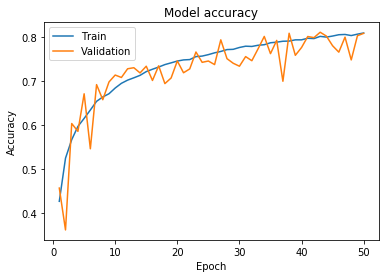

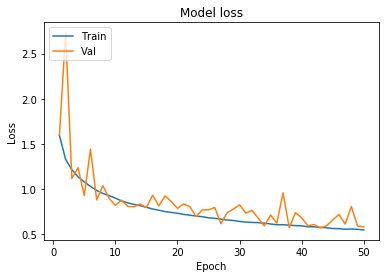

In [0]:
# Plot training & validation accuracy values
#epochs = 
epoch_range = range(1, epochs + 1)
plt.plot(epoch_range, history.history[metrix_names[0]])
plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Show result for every class in *table*:

In [0]:
y_pred = model.predict_classes(input_test_data)
conf_matrix = confusion_matrix(output_test_data, y_pred)
plot_confusion_matrix(conf_matrix,
                      figsize = (15, 11),
                      colorbar = True,                       
                      show_normed = True,
                      show_absolute = False)                      

## **Saving**

### Saving result to *colab*:

In [0]:
with open("model_best.json", 'w') as json_file:
  json_file.write(model.to_json())
model.save_weights("model_best.h5")

In [0]:
!ls

model_best.h5  model_best.json	sample_data


In [0]:
!rm -rf 'model_6.json'

### Saving result to my *computer* from *colab*

In [0]:
files.download("model_best.json")

In [0]:
files.download("model_best.h5")

## **Loading**

In [0]:
from google.colab import files
files.upload()

In [0]:
model = load_model("model_3.h5")